<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import cv, Pool
from xgboost import XGBRegressor as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Рассматриваем данные. Интервал - 10минут.

Преобразуем столбец datetime в индекс:

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

In [4]:
df = df.sort_index()

In [5]:
df.index.is_monotonic

True

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков в данных нет, тип данных - int. Можем двигаться дальше.

## Анализ

Рассмотрим сначала общую картину:

<AxesSubplot:xlabel='datetime'>

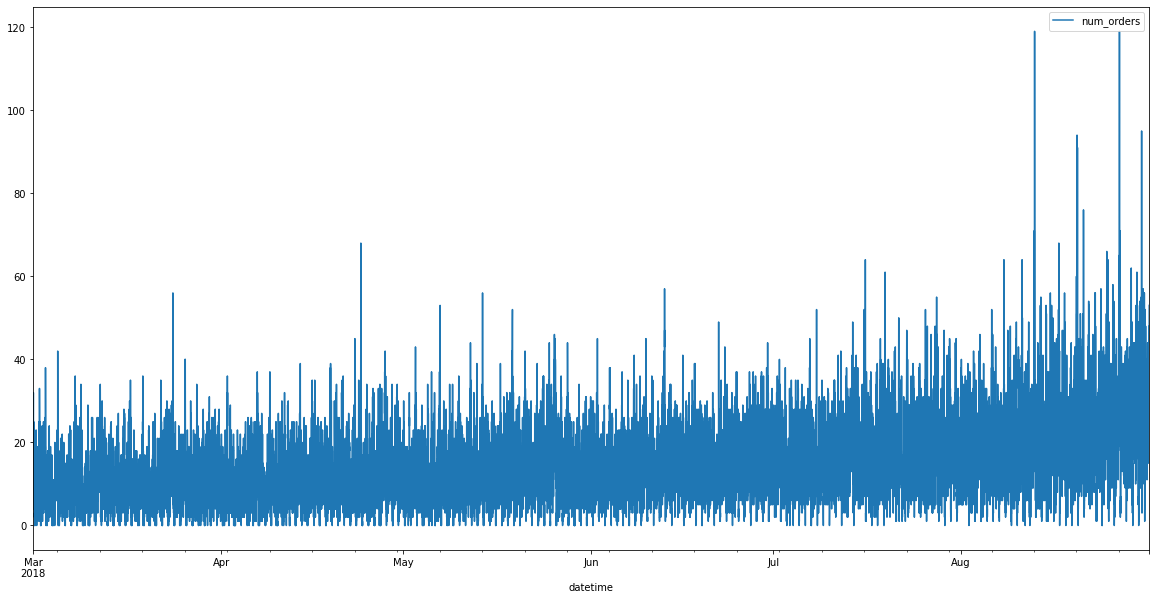

In [7]:
df.plot(figsize=(20,10))

Так как интервал у нас изначально - 10мин, график очень плотный, детали по нему не очень понятня. Но в целом можем наблюдать увеличение заказов к сентябрю. Приложение становится популярным.

Сделаем ресемплирование по одному часу.

<AxesSubplot:xlabel='datetime'>

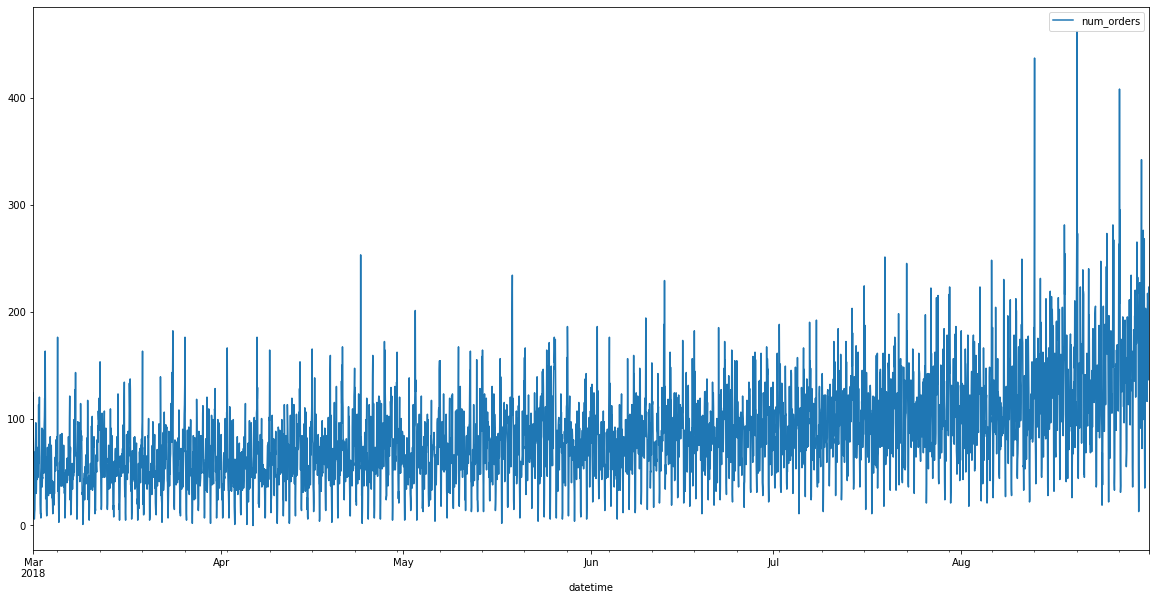

In [8]:
df = df.resample('1H').sum()
df.plot(figsize=(20,10))

Разобьем дату на неделю и час для дальнейшего анализа

In [9]:
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday

In [10]:
df

,num_orders,hour,weekday
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3
...,...,...,...
2018-08-31 19:00:00,136,19,4
2018-08-31 20:00:00,154,20,4
2018-08-31 21:00:00,159,21,4


Проанализируем взаимосвязь часа и количества заказов:

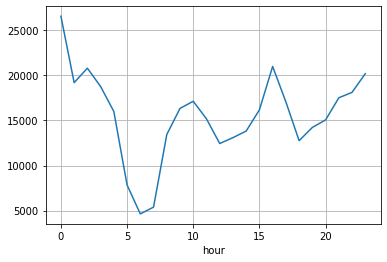

In [11]:
df.groupby('hour')['num_orders'].agg('sum').plot()
plt.grid()

In [12]:
df.groupby('hour')['num_orders'].agg('sum').sort_values(ascending=False)

hour
0     26570
16    21003
2     20805
23    20197
1     19203
3     18772
22    18124
21    17519
10    17134
17    17061
9     16345
15    16182
4     15991
11    15178
20    15062
19    14230
14    13830
8     13441
13    13096
18    12762
12    12444
5      7844
7      5386
6      4632
Name: num_orders, dtype: int64

Пиковые часы: 0, 16, 2, 23, 1

Самые спокойные: 5, 6, 7

Стоит их выделить в отдельные фичи.

Теперь проверим взаимосвязь дня недели и количества заказов за этот день:

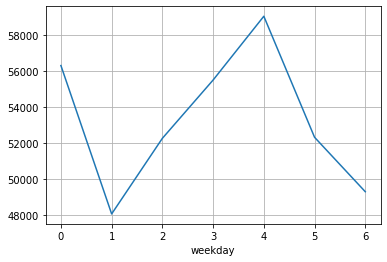

In [13]:
df.groupby('weekday')['num_orders'].agg('sum').plot()
plt.grid()

In [14]:
df.groupby('weekday')['num_orders'].agg('sum').sort_values(ascending=False)

weekday
4    59059
0    56314
3    55508
5    52321
2    52263
6    49291
1    48055
Name: num_orders, dtype: int64

Итак, самый активный день: пятница, стоит выделить ее отдельной фичой

***Функция для новых фичей***

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    df['is_friday'] = df.weekday.isin([4])*1
    df['is_peak_hour'] = df.hour.isin([0, 16, 2, 23])*1 
    df['is_down_hour'] = df.hour.isin([6, 7])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)

    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(rolling_mean_size).mean() 

In [16]:
make_features(df, 5, 5)

In [17]:
df.head()

,num_orders,hour,weekday,is_friday,is_peak_hour,is_down_hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,0,0,0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,0,1,0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,0,0,0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,0,0,0,66.0,71.0,85.0,124.0,NaN,NaN


In [18]:
df = df.dropna()

In [19]:
df.head()

,num_orders,hour,weekday,is_friday,is_peak_hour,is_down_hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 05:00:00,6,5,3,0,0,0,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,6,3,0,0,1,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,7,3,0,0,1,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,8,3,0,0,0,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,9,3,0,0,0,34.0,15.0,12.0,6.0,43.0,22.0


Добавляем необходимые фичи:

In [20]:
# df['is_friday'] = df.weekday.isin([4])*1
# df['is_peak_hour'] = df.hour.isin([0, 16, 2, 23])*1 #Удалить, если не станет лучше
# df['is_down_hour'] = df.hour.isin([6, 7])*1

In [21]:
df

,num_orders,hour,weekday,is_friday,is_peak_hour,is_down_hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 05:00:00,6,5,3,0,0,0,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,6,3,0,0,1,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,7,3,0,0,1,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,8,3,0,0,0,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,9,3,0,0,0,34.0,15.0,12.0,6.0,43.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,1,0,0,207.0,217.0,197.0,116.0,133.0,174.0
2018-08-31 20:00:00,154,20,4,1,0,0,136.0,207.0,217.0,197.0,116.0,174.6
2018-08-31 21:00:00,159,21,4,1,0,0,154.0,136.0,207.0,217.0,197.0,182.2


## Обучение

Делим данные на train и test.

Для анализа будем использовать модели:
- LinearRegression
- Catboost
- XGBoost
- LGBMRegressor
    

In [22]:
X = df.drop(columns=['num_orders'])
y = df.num_orders

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### LinearRegression

In [24]:
lr = LinearRegression()

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

In [26]:
cv_results_lr = -1 * cross_val_score(lr, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

In [27]:
cv_lr_train = cv_results_lr.mean()
cv_lr_train

31.666587179058723

### Catboost

In [28]:
train_data = Pool(data=X_train,
                  label=y_train,
                 )
test_data = Pool(data=X_test,
                  label=y_test,
                 )

In [29]:
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'learning_rate': 0.15,
          'random_seed': 19,
          'verbose':100}

Запустим кросс-валидацию

In [30]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200,
    type='TimeSeries'
)

Training on fold [0/5]

bestTest = 29.9122672
bestIteration = 108

Training on fold [1/5]

bestTest = 25.37223012
bestIteration = 159

Training on fold [2/5]

bestTest = 25.05057653
bestIteration = 217

Training on fold [3/5]

bestTest = 28.00863272
bestIteration = 110

Training on fold [4/5]

bestTest = 26.30583025
bestIteration = 411



В таблице cv_data показаны средние значения метрик по количеству фолдов, которые мы выбрали. В данном случае 5.

In [31]:
cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,83.879158,1.997617,83.327638,0.589690
1,1,74.586454,1.907196,73.891614,0.798667
2,2,66.487084,2.031899,65.600040,0.992708
3,3,59.839016,2.106048,58.870047,1.136983
4,4,54.079267,2.143953,53.038665,1.230296


In [32]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
206,206,27.033257,2.102442,14.422854,3.355872


In [33]:
cv_catboost_train = cv_data['test-RMSE-mean'].min()

### XGBoost

In [34]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor()
param_search = {'max_depth' : [3, 5]}

gsearch = GridSearchCV(estimator=model_xgb, cv=tscv,
                        param_grid=param_search, scoring='neg_root_mean_squared_error')
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
             

In [35]:
gsearch.best_params_

{'max_depth': 3}

In [36]:
#КОД РЕВЬЮЕРА
abs(gsearch.best_score_)

27.64378363103238

In [37]:
best_xgb = gsearch.best_estimator_

In [38]:
grid_xgb_train = abs(gsearch.best_score_)
grid_xgb_train

27.64378363103238

### Random Forest

In [39]:
#КОД РЕВЬЮЕРА
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [40]:
#КОД РЕВЬЮЕРА
# forest_model = RandomForestClassifier()
forest_model = RandomForestRegressor()

In [41]:
parametrs = {'n_estimators': [30, 50],
             'max_depth': [2, 5, 7, 10]}

In [42]:
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=3)
def RMSE(target, prediction):
    return (mean_squared_error(target, prediction, squared=False))

RMSE_scorer = make_scorer(RMSE, greater_is_better=False) 

In [43]:
grid_search_cv = GridSearchCV(forest_model, parametrs, cv=tscv, scoring=RMSE_scorer)

In [44]:
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 7, 10], 'n_estimators': [30, 50]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [45]:
grid_search_cv.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [46]:
#КОД РЕВЬЮЕРА
abs(grid_search_cv.best_score_)

28.50668078654081

In [47]:
grid_forest_train = abs(grid_search_cv.best_score_)
grid_forest_train

28.50668078654081

### LGBMRegressor

In [48]:
import lightgbm as lgb

In [49]:
params = {
    'task': 'train', 
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.1,
    'metric': 'root_mean_squared_error',
    'verbose': 100
}

In [50]:
lgb_model = lgb.LGBMRegressor(**params)

In [51]:
cv_results_LGBMR = -1 * cross_val_score(lgb_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.875797
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.256523
[LightGBM] [Debug] init for col-wise cost 0.000509 seconds, init for row-wise cost 0.000333 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 993, number of used features: 11
[LightGBM] [Info] Start training from score 83.979859
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a 

In [52]:
cv_lgb_train = cv_results_LGBMR.mean()
cv_lgb_train

27.233575811731843

## Тестирование

In [53]:
models_table = pd.DataFrame({
    'Model': ['LinearR', 'CatBoost', 'XGBoost', 
              'RandomF','LGBMRegressor'],
    'Train_RMSE': [cv_lr_train, cv_catboost_train, grid_xgb_train,
                   grid_forest_train, cv_lgb_train]})
models_table.sort_values(by='Train_RMSE', ascending=True)

,Model,Train_RMSE
1,CatBoost,27.033257
4,LGBMRegressor,27.233576
2,XGBoost,27.643784
3,RandomF,28.506681
0,LinearR,31.666587


Лучшие значения на train демострирует Catboost.
Получим тестовые значения.

In [54]:
params = {'iterations': 206, # в соответствии с кросс-валидацией
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'learning_rate': 0.15,
          'random_seed': 19,
          'verbose':100}

In [55]:
catboost_model = CatBoostRegressor(**params)

In [56]:
catboost_model.fit(train_data)

0:	learn: 41.7466095	total: 2.84ms	remaining: 583ms
100:	learn: 21.4595705	total: 210ms	remaining: 219ms
200:	learn: 18.5308770	total: 415ms	remaining: 10.3ms
205:	learn: 18.3712888	total: 425ms	remaining: 0us


In [57]:
catboost_y_pred = catboost_model.predict(test_data)
catboost_test = mean_squared_error(y_test, catboost_y_pred, squared=False)
catboost_test

25.79440715394129

По условиям задания: Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. 


Итоговое значение: 25.79